# Measures of shape

The `esda.shape` module provides statistics that are used in the literature to measure the structure and regularity of polygons. These measures vary from very simple (such as the length-width difference) to very complex (such as the normalized moment of inertia). Regardless, we'll walk through computing a few of these measures for counties in Mississippi. 


Why Mississippi? Because counties on the west side of Mississippi touch the Mississippi river, with its many twists and turns. Generally speaking, we would think that counties on the left side of the state are more "irregular" than the more square counties on the right. You can see this in the map below:

In [1]:
import geopandas, libpysal
from esda import shape as shapestats
import pygeos
import matplotlib.pyplot as plt

/opt/anaconda3/envs/analysis/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
counties = geopandas.read_file(libpysal.examples.get_path("south.shp"))
ms_counties = counties.query("STATE_NAME == 'Mississippi'")

Text(0.5, 1.0, 'Mississippi Counties')

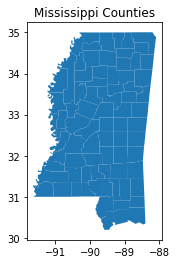

In [3]:
ms_counties.plot()
plt.title("Mississippi Counties")

The first very simple measurement is the difference between the length and width of a shape. This measure is a measurement of *elongation*. You can see the effect below, where counties that are relatively square are colored very dark blue, whereas the elongated rectangular counties are colored in light yellow. Since this measure does not "see" the twists and turns taken by the river, the river counties are judged to be relatively square and not elongated.  

Text(0.5, 1.0, 'length-width difference')

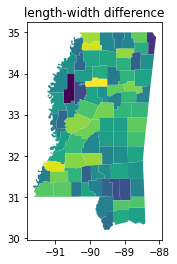

In [4]:
ms_counties.plot(shapestats.length_width_diff(ms_counties.geometry))
plt.title("length-width difference")

# Ideal Shape Measures

The next class of shape measures are usually taken to be *ideal shape* measures of compactness. This means that they construct the relationship between one (or more) aspects of the polygon (such as its perimeter or area) and compares this to an analogous value for an "ideal" shape. 

Ideal shapes come in a few flavors. 
- "relative ideal shapes" are shapes whose properties are fixed relative to the original shape. For example, the `isoperimetric_quotient`, compares the area of a polygon to the area of the circle w/ the same perimeter as the original polygon. Mathematically, these measures generally are constructed so that they vary between zero and one, and are one when the shape is the same as its relative ideal shape. Measures in this family include the `isoperimetric_quotient` and `isoareal_quotient`, as well as our implementation of the `fractal_dimension`, as will be discussed later.  
- "absolute ideal shapes" are shapes that have some fixed, known relationship to the original shape and serve as a "bound" on that shape in some manner. For example, the `convex_hull_ratio` compares the area of a polygon to the area of its convex hull. Since a convex hull is guaranteeed to be at least as large as the original shape, this measure also is between zero and one, with one meaning that a polygon is its own convex hull. Measures in this family include the `boundary_amplitude`, the `convex_hull_ratio`, the `radii_ratio`, the `diameter_ratio`, and the `minimum_bounding_circle_ratio`. 

### Absolute Ideal Shape Measures

The `boundary_amplitude` and `convex_hull_ratio` are two simple and very-related measures of shape regularity. The boundary amplitude is the perimeter of the convex hull divided by the perimeter of the original shape. This varies between zero and one, where one indicates the case where the polygon is its own convex hull. This is because the convex hull will always have *at most* the perimeter of the original shape; it will be shorter than the original shape when the shape has many concave parts that cut back into the shape. 

In the map below, you can see that the counties on the Mississippi River have very poor `boundary_amplitude` scores, since their boundaries are very wiggly: 

Text(0.5, 1.0, 'boundary amplitude')

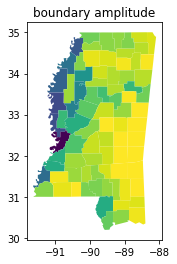

In [5]:
ms_counties.plot(shapestats.boundary_amplitude(ms_counties.geometry))
plt.title("boundary amplitude")

Related, the convex hull ratio is the *area* of the original shape divided by the area of the convex hull. This varies between zero and one again: since the convex hull always *contains* the original shape, its area is always larger. The measure, thus, is related to the `boundary_amplitude`, but will be different for different polygons, since it pertains to *area*, not *perimeter*. Generally speaking, perimeter-based measures will be more sensitive to non-convexities than areal-based measures. 

Text(0.5, 1.0, 'convex hull areal ratio')

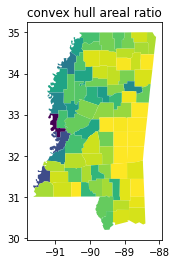

In [6]:
ms_counties.plot(shapestats.convex_hull_ratio(ms_counties.geometry))
plt.title("convex hull areal ratio")

Another useful measure is the `minimum_bounding_circle_ratio`, sometimes called the Reock measure after the author of the first journal article in which it was used to analyze congressional districts. The ratio compares the area of the original shape to the area of the smallest circle that can fully enclose the shape. This measure strongly penalizes elongation, as the minimum bounding circle has to get larger and larger to contain the shape. It also varies between zero and one, where one reflects the case where a polygon is its own bounding circle. 

Text(0.5, 1.0, 'minimum bounding circle ratio')

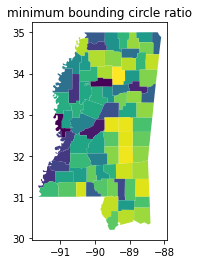

In [7]:
ms_counties.plot(shapestats.minimum_bounding_circle_ratio(ms_counties))
plt.title("minimum bounding circle ratio")

A related measure is the `radii_ratio`. Instead of comparing the areas of the two shapes, the `radii_ratio` actually mixes the reference and ideal shape concepts together. It relates the radius of the minimum bounding circle to the radius of the *isoareal* circle, or the circle that contains the same area as the original shape. 

Text(0.5, 1.0, 'radii ratio')

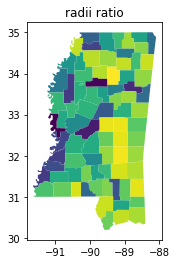

In [8]:
ms_counties.plot(shapestats.radii_ratio(ms_counties.geometry))
plt.title("radii ratio")

This measure generally performs about the same as the `minimum_bounding_circle_ratio`, with a bit more sensitivity to concavities in the shape. 

Text(0, 0.5, 'Minimum Bounding Circle Ratio')

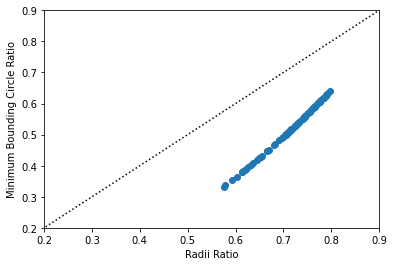

In [9]:
plt.scatter(shapestats.radii_ratio(ms_counties.geometry), 
            shapestats.minimum_bounding_circle_ratio(ms_counties.geometry))
plt.plot((0,1),(0,1), color='k', linestyle=':')
plt.xlim(.2, .9)
plt.ylim(.2, .9)
plt.xlabel("Radii Ratio")
plt.ylabel("Minimum Bounding Circle Ratio")

A similar measure to the minimum bounding circle ratio is the diameter ratio. This measures the ratio between a shape's "longest" and "shortest" diameters. This can be measured as the longest and shortest axis of a shape's minimum rotated rectangle. Alternatively, one can use the raw bounding box for shapes, but this is biased towards shapes that are east-west and north-south oriented. This again is quite a strong measure of elongation, and shapes with very large differences between their longest and shortest axes will have low scores. 

<AxesSubplot:>

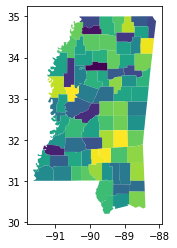

In [10]:
ms_counties.plot(shapestats.diameter_ratio(ms_counties.geometry))

### Relative ideal shape measures

These classes of shape measures construct a relationship between the observed shape and a different shape with some known relation. As we discussed before with the `radii_ratio` measure, this often looks like a circle with the same perimeter or area as the source shape. 

In the case of the `isoareal_quotient`, this relates the shape's perimeter to the perimeter of a circle with the same area as the source shape:

<AxesSubplot:>

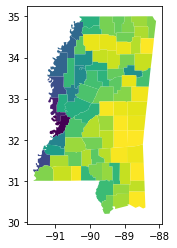

In [11]:
ms_counties.plot(shapestats.isoareal_quotient(ms_counties))

The related measure, the `isoperimetric_quotient`, relates the shape's area to the area of a circle with the same perimeter of the original shape.  

<AxesSubplot:>

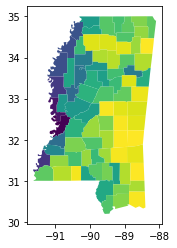

In [12]:
ms_counties.plot(shapestats.isoperimetric_quotient(ms_counties))

The two measures are directly related to one another, albeit non-linearly so

Text(0, 0.5, 'Isoperimetric Quotient')

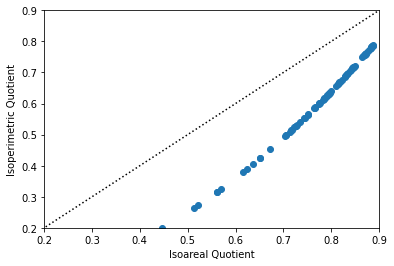

In [13]:
plt.scatter(shapestats.isoareal_quotient(ms_counties), 
            shapestats.isoperimetric_quotient(ms_counties))
plt.plot((0,1),(0,1), color='k', linestyle=':')
plt.xlim(.2, .9)
plt.ylim(.2, .9)
plt.xlabel("Isoareal Quotient")
plt.ylabel("Isoperimetric Quotient")

A final related measure is the fractal dimension of a shape. This measures the effective dimension of a shape's boundary, and generally varies between zero and two, where two implies a very convoluted boundary, and zero implies a very simple boundary. Hoever, our particular implementation approximates the true fractal dimension by assuming that shapes' boundaries move along either in a grid or a hexagonal lattice. Thus, the measure is effectively the relationship between a square (or hexagon) and the existing shape. 

<AxesSubplot:>

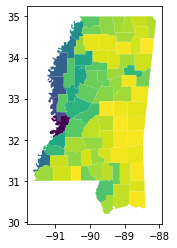

In [14]:
ms_counties.plot(shapestats.fractal_dimension(ms_counties, support='hex'))

<AxesSubplot:>

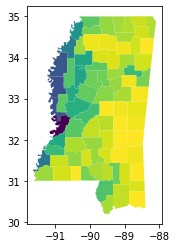

In [15]:
ms_counties.plot(shapestats.fractal_dimension(ms_counties, support='square'))

The two are also extremely related:

Text(0, 0.5, 'Fractal Dimension (square)')

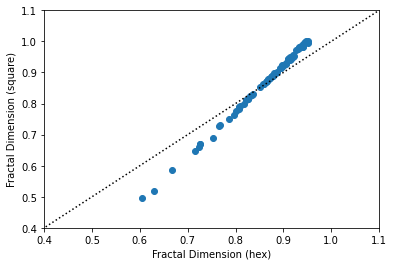

In [16]:
plt.scatter(shapestats.fractal_dimension(ms_counties, support='hex'), 
            shapestats.fractal_dimension(ms_counties, support='square'))
plt.plot((0,2),(0,2), color='k', linestyle=':')
plt.xlim(.4, 1.1)
plt.ylim(.4, 1.1)
plt.xlabel("Fractal Dimension (hex)")
plt.ylabel("Fractal Dimension (square)")

# Conclusion

There are many more shape measures in the `esda.shape` module that are useful in a large variety of applications. The ones detailed here are the most common ones encountered in literatures on redistricting, which is noly one special area where shape measurements are useful. For more information on shape measures, a good introductory conceptual paper is [by Shlomo Angel et al. (2010)](https://doi.org/10.1111/j.1541-0064.2009.00304.x) on how shape is measured in geography. 